In [1]:
from glob import glob
import numpy as np
from parcels import FieldSet, ParticleSet, JITParticle
from parcels import ErrorCode, AdvectionRK4_3D, Variable, Field
from parcels.application_kernels.TEOSseawaterdensity import PolyTEOS10_bsq

from datetime import timedelta
from datetime import datetime
import xarray as xr
import matplotlib.pyplot as plt

Connect or disconnect biofields

In [2]:
# Lorenz - MOi fields
data_path = '/storage/shared/oceanparcels/input_data/MOi/psy4v3r1/'
# bio_data_path = '/storage/shared/oceanparcels/input_data/MOi/biomer4v2r1/'

output_path = '/storage/shared/oceanparcels/output_data/' + \
    'data_Claudio/backtrack_loc0_column.nc'

ufiles = []
vfiles = []
wfiles = []
tfiles = []
sfiles = [] 
twoDfiles = []

for i in range(9, 10):
    ufiles = ufiles + sorted(glob(data_path + f'psy4v3r1-daily_U_201{i}*.nc'))
    vfiles = vfiles + sorted(glob(data_path + f'psy4v3r1-daily_V_201{i}*.nc'))
    wfiles = wfiles + sorted(glob(data_path + f'psy4v3r1-daily_W_201{i}*.nc'))
    tfiles = tfiles + sorted(glob(data_path + f'psy4v3r1-daily_T_201{i}*.nc'))    
    sfiles = sfiles + sorted(glob(data_path + f'psy4v3r1-daily_S_201{i}*.nc'))
    twoDfiles = twoDfiles + sorted(glob(data_path + f'psy4v3r1-daily_2D_201{i}*.nc'))

# phfiles = sorted(glob(bio_data_path + 'biomer4v2r1-weekly_ph_2019*.nc'))

mesh_mask = '/storage/shared/oceanparcels/input_data/MOi/domain_ORCA0083-N006/coordinates.nc'
bathy_file = '/storage/shared/oceanparcels/input_data/MOi/domain_ORCA0083-N006/bathymetry_ORCA12_V3.3.nc'
# mesh_mask_bio = '/storage/shared/oceanparcels/input_data/MOi/domain_ORCA025-N006/coordinates.nc'


In [3]:
filenames = {'U': {'lon': mesh_mask,
                   'lat': mesh_mask,
                   'depth': wfiles[0],
                   'data': ufiles},
             'V': {'lon': mesh_mask,
                   'lat': mesh_mask,
                   'depth': wfiles[0],
                   'data': vfiles},
             'W': {'lon': mesh_mask,
                   'lat': mesh_mask,
                   'depth': wfiles[0],
                   'data': wfiles}}

filenames['cons_temperature'] = {'lon': mesh_mask, 
                                 'lat': mesh_mask, 
                                 'depth': wfiles[0], 
                                 'data': tfiles}
filenames['abs_salinity'] = {'lon': mesh_mask, 
                             'lat': mesh_mask, 
                             'depth': wfiles[0], 
                             'data': sfiles}

filenames['mld'] = {'lon': mesh_mask, 
                     'lat': mesh_mask,
                     'depth': twoDfiles[0],
                     'data': twoDfiles}


# Continue the simulation

In [4]:
n_points = 100
particle_size = 1e-6 #
initial_depth = 5

start_time = datetime.strptime('2019-12-20 12:00:00', '%Y-%m-%d %H:%M:%S')
# psy4v3r1-daily_2D_2019-01-01.nc

variables = {'U': 'vozocrtx',
             'V': 'vomecrty',
             'W': 'vovecrtz'}

variables['cons_temperature'] = 'votemper'
variables['abs_salinity'] = 'vosaline'
variables['mld'] = 'somxlavt'

dimensions = {'U': {'lon': 'glamf',
                    'lat': 'gphif',
                    'depth': 'depthw',
                    'time': 'time_counter'},
              'V': {'lon': 'glamf',
                    'lat': 'gphif',
                    'depth': 'depthw',
                    'time': 'time_counter'},
              'W': {'lon': 'glamf',
                    'lat': 'gphif',
                    'depth': 'depthw',
                    'time': 'time_counter'}}

dimensions['cons_temperature'] = {'lon': 'glamf', 
                                  'lat': 'gphif',
                                  'depth': 'depthw', 
                                  'time': 'time_counter'}

dimensions['abs_salinity'] = {'lon': 'glamf', 
                              'lat': 'gphif',
                              'depth': 'depthw', 
                              'time': 'time_counter'}

dimensions['mld'] = {'lon': 'glamf', 
                              'lat': 'gphif',
                              'depth': 'deptht', 
                              'time': 'time_counter'}


#### defining domain indices

In [37]:
uf['vozocrtx'][30,:,:]

<xarray.DataArray 'vozocrtx' (y: 3059, x: 4322)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    nav_lon       (y, x) float32 72.96 73.04 73.12 73.21 ... 73.0 73.0 73.0 73.0
    nav_lat       (y, x) float32 -77.01 -77.01 -77.01 -77.01 ... 50.0 50.0 50.0
  * x             (x) int32 1 2 3 4 5 6 7 ... 4316 4317 4318 4319 4320 4321 4322
  * y             (y) int32 1 2 3 4 5 6 7 ... 3053 3054 3055 3056 3057 3058 3059
    time_counter  datetime64[ns] 2019-01-01T12:00:00
    deptht        float64 453.9
Attributes:
    units:               m s-1
    valid_min:           -10.0
    valid_max:           10.0
    long_name:           Zonal velocity
    standard_name:       sea_water_x_velocity
    short_name:          vozocrtx
    online_operation:    N/A
    interval_operation:  86400
    interval_write:      86400
    associate:           time_counter deptht nav_lat nav_lon

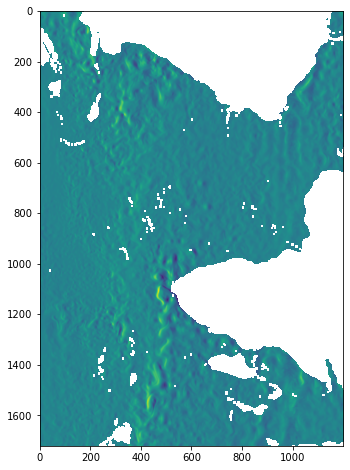

In [42]:
# indices = {'lat': range(750, 1300), 'lon': range(2900, 4000)}
uf = xr.load_dataset(ufiles[0])
# indices = {'lat': range(500, 2000), 'lon': range(2530, 4322)} # before expansion
indices = {'lat': range(500, 1700), 'lon': range(2600, 4321)}
plt.figure(figsize=(8,8))
plt.imshow(uf['vozocrtx'][30, indices['lat'], indices['lon']].T)

#### continue simulation

In [11]:
fieldset = FieldSet.from_nemo(filenames, variables, dimensions,
                              allow_time_extrapolation=False,
                              indices=indices)

         It will be opened with no decoding. Filling values might be wrongly parsed.


In [12]:
fieldset.add_constant('viscosity', 1e-6)
fieldset.add_constant('particle_density', 1380)

bathy = xr.load_dataset(bathy_file)

fieldset.add_field(Field('bathymetry', bathy['Bathymetry'].values,
                         lon=bathy['nav_lon'].values, lat=bathy['nav_lat'].values,
                         mesh='spherical'))


In [13]:
class PlasticParticle(JITParticle):
    cons_temperature = Variable('cons_temperature', dtype=np.float32, initial=fieldset.cons_temperature)
    abs_salinity = Variable('abs_salinity', dtype=np.float32, initial=fieldset.abs_salinity)
    mld = Variable('mld', dtype=np.float32, initial=fieldset.mld)
    density = Variable('density', dtype=np.float32, initial=1035)
    v_s = Variable('v_s', dtype=np.float32, initial=0)
    alpha = Variable('alpha', dtype=np.float32, initial=particle_size)


In [30]:
lon_cluster = [-180]*n_points
lat_cluster = [-35]*n_points

# depth_cluster = np.linspace(1, 5000, n_points)
depth_cluster = np.ones(n_points)*initial_depth #meters

date_cluster = [start_time]*n_points

lon_cluster = np.array(lon_cluster)+(np.random.random(len(lon_cluster))-0.5)/24
lat_cluster = np.array(lat_cluster)+(np.random.random(len(lat_cluster))-0.5)/24

In [31]:
pset = ParticleSet.from_list(fieldset=fieldset, pclass=PlasticParticle,
                             lon=lon_cluster,
                             lat=lat_cluster,
                             depth=depth_cluster,
                             time=date_cluster)


In [32]:
def delete_particle(particle, fieldset, time):
    particle.delete()

In [33]:
def GrowParticle(particle, fieldset, time):
    particle.alpha = particle.alpha - fieldset.grow_rate*particle.dt

In [34]:
def SinkingVelocity(particle, fieldset, time):
    rho_p = fieldset.particle_density ##
    rho_f = particle.density
    nu = fieldset.viscosity
    alpha = particle.alpha
    g = 9.81
    dt = particle.dt
    beta = 3*rho_f/(2*rho_p + rho_f)
    tau_p = alpha*alpha/(3*beta*nu) ## alpha*alpha
    
    seafloor = fieldset.bathymetry[time, particle.depth, particle.lat, particle.lon]
    
    if particle.depth < seafloor and particle.depth > 0:
        v_s = (1 - beta)*g*tau_p
    else:
        v_s = 0
        
    particle.v_s = v_s
    particle.depth = particle.depth + v_s*dt
    

In [35]:
def SinkingVelocity_RK4(particle, fieldset, time):
    rho_p = fieldset.particle_density ##
    rho_f = particle.density
    nu = fieldset.viscosity
    alpha = particle.alpha
    g = 9.81
    dt = particle.dt
    beta = 3*rho_f/(2*rho_p + rho_f)
    tau_p = alpha*alpha/(3*beta*nu) ## alpha*alpha
    
    seafloor = fieldset.bathymetry[time, particle.depth, particle.lat, particle.lon]
    
    if particle.depth < seafloor and particle.depth > 0:
        v_s = (1 - beta)*g*tau_p
    else:
        v_s = 0
        
    particle.v_s = v_s
    particle.depth = particle.depth + v_s*dt

In [36]:
def SampleField(particle, fielset, time):
    particle.cons_temperature = fieldset.cons_temperature[time, particle.depth, 
                                               particle.lat, particle.lon]
    particle.abs_salinity = fieldset.abs_salinity[time, particle.depth, 
                                               particle.lat, particle.lon]
    particle.mld = fieldset.mld[time, particle.depth, 
                                               particle.lat, particle.lon]


In [37]:
def periodicBC(particle, fieldset, time):
    if particle.lon <= -180.:
        particle.lon += 360.
    elif particle.lon >= 180.:
        particle.lon -= 360.

In [38]:
kernels = pset.Kernel(AdvectionRK4_3D) + pset.Kernel(SampleField) + pset.Kernel(PolyTEOS10_bsq) + pset.Kernel(periodicBC)

# Output fileii
output_file = pset.ParticleFile(name=output_path,
                                outputdt=timedelta(hours=24))

pset.execute(kernels,
             output_file=output_file,
             runtime=timedelta(days=10),
             dt=-timedelta(hours=1),
             recovery={ErrorCode.ErrorOutOfBounds: delete_particle})

output_file.close()


sh: None: command not found
INFO: Compiled ArrayPlasticParticleAdvectionRK4_3DSampleFieldPolyTEOS10_bsqperiodicBC ==> /tmp/parcels-263482/libe896e7af154b168f0b6405eaba591388_0.so
INFO: Temporary output files are stored in /storage/shared/oceanparcels/output_data/data_Claudio/out-YBXCKGVC.
INFO: You can use "parcels_convert_npydir_to_netcdf /storage/shared/oceanparcels/output_data/data_Claudio/out-YBXCKGVC" to convert these to a NetCDF file during the run.
100% (864000.0 of 864000.0) |############| Elapsed Time: 0:05:36 Time:  0:05:36


In [39]:
sim = xr.load_dataset(output_path)

In [40]:
sim

<xarray.Dataset>
Dimensions:           (traj: 100, obs: 11)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory        (traj, obs) float64 200.0 200.0 200.0 ... 299.0 299.0
    time              (traj, obs) datetime64[ns] 2019-12-20T12:00:00 ... 2019...
    lat               (traj, obs) float64 -35.02 -34.99 -34.99 ... -34.82 -34.73
    lon               (traj, obs) float64 -180.0 -179.9 -179.8 ... -179.5 -179.4
    z                 (traj, obs) float64 5.0 4.959 4.953 ... 4.522 4.464 4.639
    cons_temperature  (traj, obs) float32 20.24 20.29 20.3 ... 20.19 20.09 20.19
    abs_salinity      (traj, obs) float32 35.46 35.44 35.42 ... 35.43 35.43
    mld               (traj, obs) float32 16.63 11.96 16.67 ... 10.46 10.46 17.2
    density           (traj, obs) float32 1.035e+03 1.025e+03 ... 1.025e+03
    v_s               (traj, obs) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    alpha             (traj, obs) float32 1e-06 1e-06 1e-06 ... 1e-06 1e-06
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        v2.3.0-71-g202ef087
    parcels_mesh:           spherical

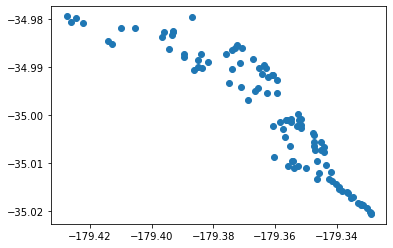

In [43]:
plt.scatter(sim['lon'][:, 10], sim['lat'][:,0])

Text(0, 0.5, 'Particle size')

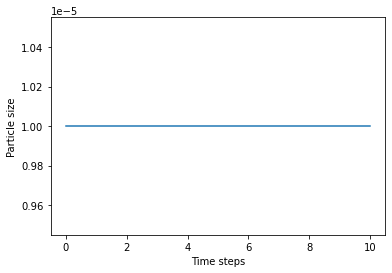

In [19]:
plt.plot(sim['alpha'][0, :])
plt.xlabel('Time steps')
plt.ylabel('Particle size')

Text(0.5, 1.0, '2019-11-22T12:00:00.000000000')

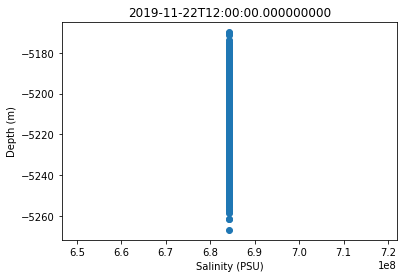

In [24]:
step = 10
plt.scatter(sim['alpha'][:,step], -sim['z'][:,step])
plt.xlabel('Salinity (PSU)')
plt.ylabel('Depth (m)')
plt.title(sim['time'][0,step].values)

Text(0.5, 1.0, '2019-11-22T12:00:00.000000000')

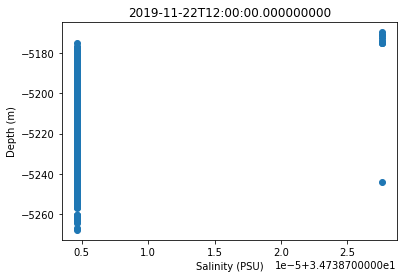

In [19]:
step = 10
plt.scatter(sim['salinity'][:,step], -sim['z'][:,step])
plt.xlabel('Salinity (PSU)')
plt.ylabel('Depth (m)')
plt.title(sim['time'][0,step].values)

Text(0.5, 1.0, '2019-11-22T12:00:00.000000000')

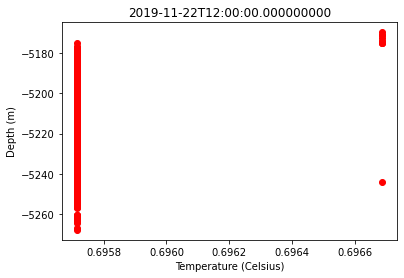

In [20]:
step = 10
plt.scatter(sim['temperature'][:,step], -sim['z'][:,step], color='r')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Depth (m)')
plt.title(sim['time'][0,step].values)

Text(0.5, 1.0, '2019-11-22T12:00:00.000000000')

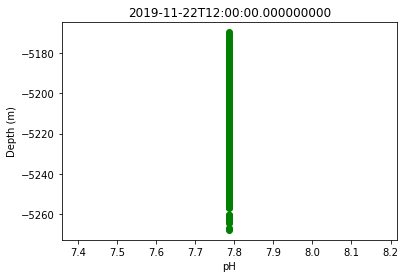

In [21]:
step = 10
plt.scatter(sim['ph'][:,step], -sim['z'][:,step], color='g')
plt.xlabel('pH')
plt.ylabel('Depth (m)')
plt.title(sim['time'][0,step].values)

Text(0, 0.5, 'Latitude')

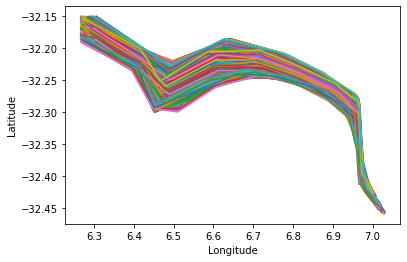

In [23]:
step = 10
for i in range(1000):
    plt.plot(sim['lon'][i,:], sim['lat'][i,:]);

plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.title(sim['time'][0,step].values)

In [3]:
sim2 = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Claudio/SA_5m_s02.nc')

In [4]:
sim2

<xarray.Dataset>
Dimensions:           (traj: 1000, obs: 301)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory        (traj, obs) float64 0.0 0.0 0.0 0.0 ... 999.0 999.0 999.0
    time              (traj, obs) datetime64[ns] 2019-12-30T12:00:00 ... 2019...
    lat               (traj, obs) float64 -32.16 -32.22 -32.3 ... -32.87 -32.84
    lon               (traj, obs) float64 6.289 6.657 7.008 ... 41.16 41.11
    z                 (traj, obs) float64 5.0 5.064 5.142 ... 65.26 64.61 63.93
    cons_temperature  (traj, obs) float32 18.89 18.94 19.01 ... 19.41 19.24
    abs_salinity      (traj, obs) float32 35.69 35.67 35.66 ... 35.62 35.62
    mld               (traj, obs) float32 0.0 46.08 50.73 ... 11.27 10.64 11.52
    alpha             (traj, obs) float32 1e-06 1e-06 1e-06 ... 1e-06 1e-06
    density           (traj, obs) float32 1.035e+03 1.025e+03 ... 1.025e+03
    v_s               (traj, obs) float32 0.0 7.538e-07 ... 7.543e-07 7.542e-07
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        v2.3.0-71-g202ef087
    parcels_mesh:           spherical

In [6]:
sim2['v_s'].shape

(1000, 301)

(7e-07, 8e-07)

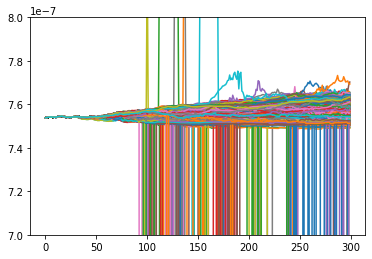

In [12]:
for i in range(1000):
    plt.plot(sim2['v_s'][i,1:])
plt.ylim(7e-7, 8e-7)

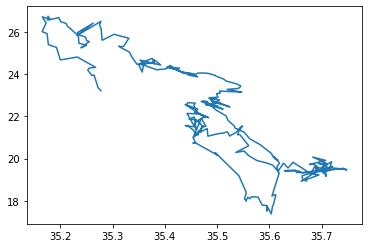

In [15]:
plt.plot(sim2['abs_salinity'][0, 1:], sim2['cons_temperature'][0, 1:])

Text(0, 0.5, 'Latitude')

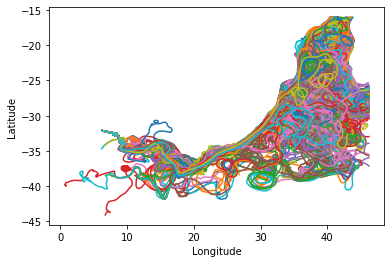

In [5]:
step = 10
for i in range(1000):
    plt.plot(sim2['lon'][i,:], sim2['lat'][i,:]);

plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [45]:
step = 10
plt.scatter(sim2['salinity'][:,step], -sim2['z'][:,step])
plt.xlabel('Salinity (PSU)')
plt.ylabel('Depth (m)')
plt.title(sim2['time'][0,step].values)

KeyError: 'salinity'